In [13]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt

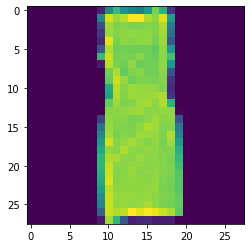

In [15]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
#you can visualize it
plt.imshow(images[1100]);

In [18]:
# #submission to part 1, you should make this into a .py file
# n=len(dataset)
# mse=0
# gatecount=0

# # Functions 'encode' and 'decode' are dummy.
# def encode(image):
#     q = qiskit.QuantumRegister(3)
#     circuit = qiskit.QuantumCircuit(q)
#     if image[0][0]==0:
#         circuit.rx(np.pi,0)
#     return circuit

# def decode(histogram):
#     if 1 in histogram.keys():
#         image=[[0,0],[0,0]]
#     else:
#         image=[[1,1],[1,1]]
#     return image

# def run_part1(image):
#     #encode image into a circuit
#     circuit = encode(image)

#     #simulate circuit
#     histogram = simulate(circuit)

#     #reconstruct the image
#     image_re = decode(histogram)

#     return circuit,image_re

In [17]:
# #how we grade your submission
# n=len(dataset)
# mse=0
# gatecount=0

# for data in dataset:
#     #encode image into circuit
#     circuit,image_re=run_part1(data['image'])
    
#     #count the number of 2qubit gates used
#     gatecount+=count_gates(circuit)[2]
    
#     #calculate mse
#     mse+=image_mse(data['image'],image_re)
    
# #fidelity of reconstruction
# f=1-mse
# gatecount=gatecount/n

# #score for part1 
# print(f*(0.999**gatecount))

In [19]:
# def encode(image):
#     q = qiskit.QuantumRegister(3)
#     circuit = qiskit.QuantumCircuit(q)
#     circuit.h([0, 1, 2])
#     return circuit

In [23]:
from qiskit import QuantumCircuit
from sklearn.decomposition import PCA

def encode_amplitude(images, image_index, n_qubits):
    N_images = len(images)
    # We have 28x28 images as input
    # - we can do amplitude encoding of a normalized amplitude vector that has size of 2 ** n (full power of two)
    # 28 x 28 = 784 doesn't fit into a full power of two, so we use PCA to reduce the dimensionality to fit it 
    # into n_qubits (parametrized)
    
    
    # [apply PCA]
    # Create an instance of PCA
    pca = PCA(n_components=2**n_qubits)

    # Fit PCA on your 784-dimensional data
    data = images.reshape(N_images, 28 * 28)
    pca.fit(data)

    # Apply dimensionality reduction on your data
    data_pca = pca.transform(data)
    image = images[image_index]
    image_pca = data_pca[image_index]
    min_ = image_pca.min()
    image_pca = image_pca - min_
    
    
    # [normalize]
    def normalize(row):
        #We calculate the squareroot of the sum of the square values of the row
        normalization_factor = np.sqrt(np.sum(row**2)) 
        if normalization_factor == 0.:
            #If the sum is zero we return a 0
            return 0.0
        #Else we divide each value between the sum value above
        row = row / normalization_factor
        return row, normalization_factor
    
    image_pca_normalized, normalization_factor = normalize(image_pca)
    
    
    desired_state = image_pca_normalized
    
    ##########
    # Amplitude Encoding
    qc = QuantumCircuit(n_qubits)
    qc.initialize(desired_state)
    qc_decomposed = qc.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose()

    ##########
    
    decoder_params = dict(
        pca=pca,
        min_=min_,
        normalization_factor=normalization_factor,
        n_qubits=n_qubits,
        image=image
    )
    
    return qc_decomposed, decoder_params

def decode_amplitude(histogram, normalization_factor, min_, pca, n_qubits, image):
    
    histogram_array = np.zeros(2 ** n_qubits)
    
    for i in range(2 ** n_qubits):
        histogram_array[i] = histogram.get(i, 0)

    root = np.sqrt(histogram_array)
    root = root * normalization_factor
    root = root + min_
    reconstruction = pca.inverse_transform([root])
    #print(reconstruction)
    reconstructed_image = reconstruction[0].reshape(28, 28)
    
    return reconstructed_image

qc, decoder_params = encode_amplitude(images, 250, 6)    

histogram = simulate(qc)

image = decode_amplitude(histogram, **decoder_params)

In [24]:
qc.depth()

121

In [25]:
count_gates(qc)
# 4 qubits -> 2x qubit gates
# 6 qubits -> 62 2-qubit gates
# 8 qubits -> 253 2-qubit gates

Counter({1: 69, 2: 62})

In [27]:
import tqdm

def run_part1(images, image_index, n_qubits=8):
    #encode image into a circuit
    circuit, decoder_params = encode_amplitude(images, image_index, n_qubits=n_qubits)

    #simulate circuit
    histogram = simulate(circuit)

    #reconstruct the image
    image_re = decode_amplitude(histogram, **decoder_params)

    return circuit,image_re

#how we grade your submission

n=len(dataset)
mse=0
gatecount=0

max_iter = 50

n_qubits = 4

# 1 - mse with 4 qubits - > 0.18 
# 2 - mse with 6 qubits -> 0.5868325769829128

for i, data in tqdm.tqdm(enumerate(images)):
    #encode image into circuit
    circuit, image_re =run_part1(images, i, n_qubits=n_qubits)
    
    #count the number of 2qubit gates used
    gatecount+=count_gates(circuit)[2]
    
    #calculate mse
    #print(images[i].shape)
    #print(image_re.shape)
    images_orig = images[i] * 255
    image_re *= 255
    
    mse+=image_mse(images_orig,image_re)
    
    if i == max_iter:
        break
    
#fidelity of reconstruction
f=1-mse
gatecount=gatecount/max_iter

#score for part1 
print(f*(0.999**gatecount))

50it [00:18,  2.75it/s]

0.18310360453121785


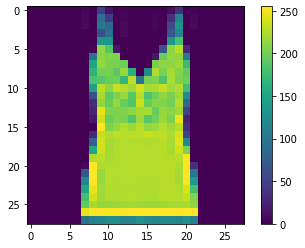

In [29]:
plt.imshow(images[max_iter] * 255 * 255)
plt.colorbar()

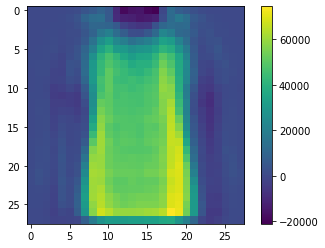

In [30]:
plt.imshow(image_re * 255 * 255)
plt.colorbar()

In [31]:
image_mse(images[max_iter], image_re)

0.23335430648607078

In [34]:
import pandas as pd
pd.DataFrame(labels, columns=["label"]).query("label==True")

,label
0,True
1,True
2,True
3,True
4,True
...,...
495,True
496,True
497,True
498,True


In [35]:
"""
Shirt vs no shirt
no shirt pueden ser distintos
"""

'\nShirt vs no shirt\nno shirt pueden ser distintos\n'

In [44]:
#qc.decompose().decompose().decompose().decompose().draw()

In [37]:
qc_decomposed = qc.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose()
count_gates(qc_decomposed)

Counter({1: 69, 2: 62})

In [38]:
histogram.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [39]:
import cirq
import numpy as np
import pickle
import json
import os
import sys
from collections import Counter
from sklearn.metrics import mean_squared_error

In [52]:
if len(sys.argv) > 1:
    data_path = sys.argv[1]
else:
    data_path = '.'

#define utility functions

def simulate(circuit: cirq.Circuit) -> dict:
    """This function simulates a Cirq circuit (without measurement) and outputs results in the format of histogram.
    """
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    
    state_vector=result.final_state_vector
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram

def histogram_to_category(histogram):
    """This function takes a histogram representation of circuit execution results, and processes into labels as described in
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive

def count_gates(circuit: cirq.Circuit):
    """Returns the number of 1-qubit gates, number of 2-qubit gates, number of 3-qubit gates...."""
    counter=Counter([len(op.qubits) for op in circuit.all_operations()])
    
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter

def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(255*image1,255*image2)

def test():
    #load the actual hackthon data (fashion-mnist)
    images=np.load('data/images.npy')
    labels=np.load('data/labels.npy')
    
    #test part 1
    n=len(images)
    mse=0
    gatecount=0

    for image in images:
        #encode image into circuit
        circuit,image_re=run_part1(image)

        #count the number of 2qubit gates used
        gatecount+=count_gates(circuit)[2]

        #calculate mse
        mse+=image_mse(image,image_re)

    #fidelity of reconstruction
    f=1-mse/n
    gatecount=gatecount/n

    #score for part1
    score_part1=f*(0.999**gatecount)
    
    #test part 2
    
    score=0
    gatecount=0
    n=len(images)

    for i in range(n):
        #run part 2
        circuit,label=run_part2(images[i])

        #count the gate used in the circuit for score calculation
        gatecount+=count_gates(circuit)[2]

        #check label
        if label==labels[i]:
            score+=1
    #score
    score=score/n
    gatecount=gatecount/n

    score_part2=score*(0.999**gatecount)
    
    print(score_part1, ",", score_part2, ",", data_path, sep="")    

In [54]:
############################
#      YOUR CODE HERE      #
############################
def encode_amplitude(images, image_index, n_qubits):
    N_images = len(images)
    # We have 28x28 images as input
    # - we can do amplitude encoding of a normalized amplitude vector that has size of 2 ** n (full power of two)
    # 28 x 28 = 784 doesn't fit into a full power of two, so we use PCA to reduce the dimensionality to fit it 
    # into n_qubits (parametrized)
    
    
    # [apply PCA]
    # Create an instance of PCA
    pca = PCA(n_components=2**n_qubits)

    # Fit PCA on your 784-dimensional data
    data = images.reshape(N_images, 28 * 28)
    pca.fit(data)

    # Apply dimensionality reduction on your data
    data_pca = pca.transform(data)
    image = images[image_index]
    image_pca = data_pca[image_index]
    min_ = image_pca.min()
    image_pca = image_pca - min_
    
    
    # [normalize]
    def normalize(row):
        #We calculate the squareroot of the sum of the square values of the row
        normalization_factor = np.sqrt(np.sum(row**2)) 
        if normalization_factor == 0.:
            #If the sum is zero we return a 0
            return 0.0
        #Else we divide each value between the sum value above
        row = row / normalization_factor
        return row, normalization_factor
    
    image_pca_normalized, normalization_factor = normalize(image_pca)
    
    
    desired_state = image_pca_normalized
    
    ##########
    # Amplitude Encoding
    qc = QuantumCircuit(n_qubits)
    qc.initialize(desired_state)
    qc_decomposed = qc.decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose().decompose()

    ##########
    
    decoder_params = dict(
        pca=pca,
        min_=min_,
        normalization_factor=normalization_factor,
        n_qubits=n_qubits,
        image=image
    )
    
    return qc_decomposed, decoder_params

def decode_amplitude(histogram, normalization_factor, min_, pca, n_qubits, image):
    
    histogram_array = np.zeros(2 ** n_qubits)
    
    for i in range(2 ** n_qubits):
        histogram_array[i] = histogram.get(i, 0)

    root = np.sqrt(histogram_array)
    root = root * normalization_factor
    root = root + min_
    reconstruction = pca.inverse_transform([root])
    #print(reconstruction)
    reconstructed_image = reconstruction[0].reshape(28, 28)
    
    return reconstructed_image

def run_part1(images, image_index, n_qubits=8):
    #encode image into a circuit
    circuit, decoder_params = encode_amplitude(images, image_index, n_qubits=n_qubits)

    #simulate circuit
    histogram = simulate(circuit)

    #reconstruct the image
    image_re = decode_amplitude(histogram, **decoder_params)

    return circuit,image_re

# def run_part2(image):
#     # load the quantum classifier circuit
#     with open('quantum_classifier.pickle', 'rb') as f:
#         classifier=pickle.load(f)
    
#     #encode image into circuit
#     circuit=encode(image)
    
#     #append with classifier circuit
    
#     circuit.append(classifier)
    
#     #simulate circuit
#     histogram=simulate(circuit)
        
#     #convert histogram to category
#     label=histogram_to_category(histogram)
    
#     #thresholding the label, any way you want
#     if label>0.5:
#         label=1
#     else:
#         label=0
        
#     return circuit,label

############################
#      END YOUR CODE       #
############################

test()

TypeError: run_part1() missing 1 required positional argument: 'image_index'